# Trust Region Policy Optimization (TRPO)

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy
import time
from IPython.display import display, clear_output
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

from utils.plots import *
from utils.models import *

## Config

In [8]:
CONFIG = {
    'TRPO': {
        'gamma': 0.99,            
        'num_episodes': 200,     
        'val_fn_lr': 5e-4,        
        'val_fn_epochs': 20,      
        'val_fn_hidden_sizes': [64, 64], 
        'delta': 0.005,
        'alpha': 0.8,             
        'max_backtracks': 20,     
    },
    'MLPPolicy_hidden_sizes': [64, 64],
    'animation': {
        'FPS': None,
        'do_truncate': True,
    },
    'plots_info': {
        'subplt_shape': (1,2),
        'figsize': (12,4),
        'subplts_info': [
            {'key': "rewards",
            'title': "Smoothed Rewards",
            'xlabel': "Episodes",
            'ylabel': "Reward"},
            
            {'key': "trpo_loss",
            'title': "Smooth TRPO Loss",
            'xlabel': "Timesteps",
            'ylabel': "Loss"}
        ],
    },
}

## Creating the environment

In [3]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

## Trust Region Policy Optimization

In [4]:
torch.autograd.set_detect_anomaly(True)

def unflatten(flat_tensor, model):
    shapes = [p.shape for p in model.parameters()]
    params = []
    idx = 0
    for shape in shapes:
        size = torch.tensor(shape).prod().item()
        param = flat_tensor[idx: idx + size].view(shape)
        params.append(param)
        idx += size
    return params

@torch.no_grad()
def flat_params(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])


@torch.no_grad()
def set_flat_params(model, flat_vector):
    idx = 0
    for p in model.parameters():
        size = p.numel()
        p.data.copy_(flat_vector[idx:idx+size].view_as(p))
        idx += size
    

def fisher_vector_product(policy_net, states, old_probs, damping=1e-2):
    def fvp_fn(v):
        # Get current policy probabilities
        current_probs = policy_net(states)
        
        # Create distributions
        current_dist = torch.distributions.Categorical(current_probs)
        old_dist = torch.distributions.Categorical(old_probs.detach())  
        
        # Compute KL divergence (old || current)
        kl = torch.distributions.kl.kl_divergence(old_dist, current_dist).mean()
        
        # First gradient (gradient of KL)
        grads = torch.autograd.grad(kl, policy_net.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([g.contiguous().view(-1) for g in grads])
        
        # Gradient vector product
        grad_v = torch.dot(flat_grad_kl, v)
        
        # Hessian vector product
        hv = torch.autograd.grad(grad_v, policy_net.parameters(), retain_graph = True)
        flat_hv = torch.cat([g.contiguous().view(-1) for g in hv])
                
        # Add damping for numerical stability
        del kl, grads, grad_v
        return flat_hv + damping * v
    return fvp_fn


def conjugate_gradients(fvp_fn, b, n_iters=10, residual_tol=1e-10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)

    for i in range(n_iters):
        Avp = fvp_fn(p)  # Fisher-vector product
        alpha = rdotr / torch.dot(p, Avp + 1e-8)
        x = x + alpha * p
        r = r + alpha * Avp
        new_rdotr = torch.dot(r, r)

        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr

    return x


def TRPO(env, policy, gamma = 1.0, num_episodes = 10,
         val_fn_lr = 1e-3, val_fn_epochs = 10, val_fn_hidden_sizes = [16],
         delta = 0.001, alpha = 0.5, max_backtracks = 10):

    s_dims = env.observation_space.shape[0]
    a_dims = env.action_space.n
    
    stats = {'ep_length': [],
             'rewards': [],
             'completions': 0,
             'trpo_loss': [],
             'val_loss': []}
    
    value_fn = MLP(s_dims, 1, val_fn_hidden_sizes)
    mse_loss = nn.MSELoss()
    
    value_optimizer = torch.optim.Adam(value_fn.parameters(), lr = val_fn_lr)
    
    for e in range(1, num_episodes + 1):

        if e % 1 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes} ({100*e/num_episodes:.2f}%)', end = '')
            

        H = defaultdict(lambda: [])
        T = 0
        s, _ = env.reset()
        stats['rewards'].append(0.0)
        while True:
            T += 1
            probs = policy(torch.as_tensor(s))
            a = np.random.choice(list(range(a_dims)), p = probs.detach().numpy())

            s_n, r, terminated, truncated, info = env.step(a)
            stats['rewards'][-1] += r

            H['s'] += [s]
            H['a'] += [a]
            H['r'] += [r]
            H['probs'] += [probs]
            H['log_probs'] += [torch.log(probs[a])]
            
            if terminated or truncated:
                ep_len_str = str(T)
                ep_len_str = "0"*(3-len(ep_len_str)) + ep_len_str
                print(f" -- ep_length = {ep_len_str}", end= '')
                
                stats['ep_length'] += [T]
                if truncated:
                    stats['completions'] += 1
                break

            s = s_n
            
        R = 0
        Rt_tensor = torch.zeros(T)
        for t in reversed(range(T)):
            R = H['r'][t] + gamma * R
            Rt_tensor[t] = R
            
        states_tensor = torch.as_tensor(np.asarray(H['s']), dtype=torch.float32)
        actions_tensor = torch.as_tensor(np.asarray(H['a']), dtype=torch.long)
        probs_tensor = torch.stack(H['probs'])
        log_probs_tensor = torch.stack(H['log_probs'])
        
        adv_tensor = Rt_tensor - value_fn(states_tensor).detach()
        
        vpg_loss = torch.sum(log_probs_tensor * adv_tensor)        
        
        g_k = torch.autograd.grad(vpg_loss, policy.parameters(), create_graph=True)
        flat_g_k = torch.cat([grad.contiguous().view(-1) for grad in g_k])

        fvp_fn = fisher_vector_product(policy, states_tensor, probs_tensor)
        step_dir = conjugate_gradients(fvp_fn, flat_g_k)

        F_xk = fvp_fn(step_dir)
        xk_F_xk = step_dir.dot(F_xk)

        step_size = torch.sqrt(2*delta/(xk_F_xk + 1e-8))
        final_step = step_size * step_dir
        
        expected_improve = flat_g_k.dot(final_step)
        old_params = flat_params(policy)
        
        success = False
        for i,step_frac in enumerate(alpha**np.arange(max_backtracks)):
            new_params = old_params + step_frac * final_step
            set_flat_params(policy, new_params)
        
            with torch.no_grad():
                new_probs = policy(states_tensor)
                new_log_probs = torch.log(new_probs[range(T), actions_tensor])
                new_loss = torch.sum(new_log_probs * adv_tensor).detach()
                
                kl = torch.distributions.kl.kl_divergence(
                    torch.distributions.Categorical(probs_tensor),
                    torch.distributions.Categorical(new_probs)
                ).mean()

                actual_improve = new_loss.item() - vpg_loss.item()
        
            if actual_improve >= expected_improve*step_frac and kl <= delta:
                print(f" -- step_frac = {step_frac:.3f}", end = '')
                success = True
                stats['trpo_loss'].append(new_loss)
                break
                    
        if not success:
            print(f" -- step_frac = None  ", end= '')
            set_flat_params(policy, old_params)
            stats['trpo_loss'].append(0.0)
        
        val_avg_loss = 0.0  
        for epoch in range(val_fn_epochs):
            V_pred = value_fn(states_tensor).view(-1)
            
            value_optimizer.zero_grad()
            
            val_loss = mse_loss(V_pred, Rt_tensor) 
            val_avg_loss += val_loss.item()
            
            val_loss.backward()
            value_optimizer.step()
            
        val_avg_loss /= val_fn_epochs
        stats['val_loss'] += [val_avg_loss]
        sys.stdout.flush()

    return stats

## MLP Policy

In [5]:
s_dims = env.observation_space.shape[0]
a_dims = env.action_space.n

policy = MLPPolicyDiscrete(s_dims, a_dims, CONFIG['MLPPolicy_hidden_sizes'])
stats = TRPO(env, policy, **CONFIG['TRPO'])

Episode : 200/200 (100.00%) -- ep_length = 074 -- step_frac = 0.800

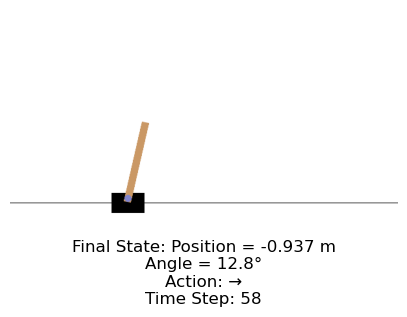

In [6]:
animate_policy(env, policy, **CONFIG['animation'])

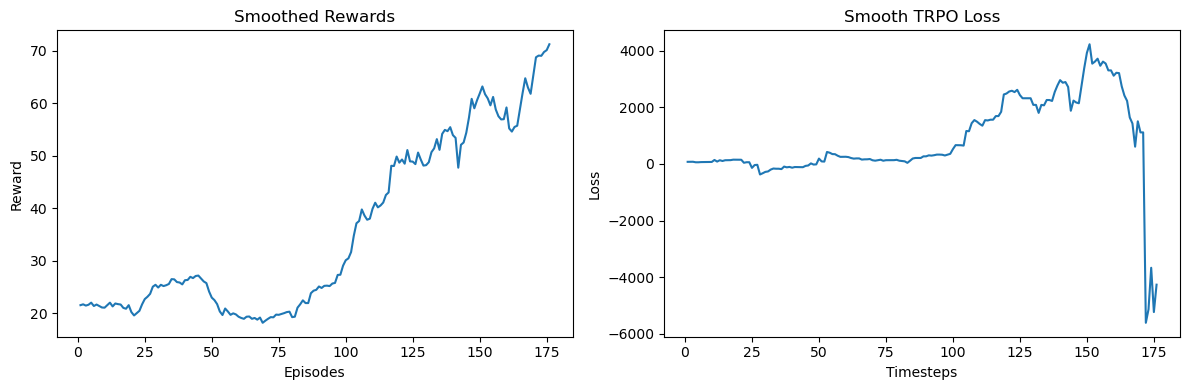

In [9]:
plot_stats(stats, CONFIG['plots_info'], 25)